#K-nearest neighbors
This algorithm is very simple, and does not need a training phase.
**It classifies a new point according to its K nearest neighbors, for which the category is known.**

It gives good results when the number of points is not too big, and the points don't have too many features:
- Indeed, it needs to load all the points (ie. all the dataset) in memory. When there is too much data, it does not fit in memory and the computing time increases exponentially, because it needs to compute the distance between all the pairs of points.
- If the points have too many features, we fall into "the curse of dimensionality", see the introduction chapter.

Some improvements have been developed, which allow to work in high dimensionality spaces. For example, one can compute a statistical estimation of the distance of the points, which removes the necessity to evaluate the between all the pairs: https://erikbern.com/2018/02/15/new-benchmarks-for-approximate-nearest-neighbors.html

Here, we will focus the simple version of the algorithm, in order to fully understand its principles.

**In this chapter, we will introduce a crucial notion: the evaluation of the results with the test set, different from the training set.** We will use the most common metric: the **accuracy**, and the default distance: **euclidian distance**. As we will see in the next chapters, there are some other metrics, that you should select according to the data and your objective. There are also dozens of ways to evaluate a distance: https://www.researchgate.net/publication/319135278_Distance_and_Similarity_Measures_Effect_on_the_Performance_of_K-Nearest_Neighbor_Classifier_-_A_Review

As for other machine learning algorithms, you have to chose a way of evaluating the results (here, we chose accuracy), and you will have to tune the parameters of the algorithm: here, you can chose the formula for evaluating a distance, and the number of neighbors, ie. the much talked about K. As for other algorithms, there is no rule for forecasting the best parameters, because they depend on the data. Therefore, you have to find out "as cleverly as possible" and select the settings which produced the best results.

##Intuition: fruits classification
**Let's take a simple example: we want to predict the type of fruits according to their color, weight, and shape.**

In the dataset, there are 4 kinds of fruits: apples, mandarines, oranges, and lemons.

The dataset contains a list of known fruits, associated to their caracteristics.

**Is the algorithm able to predict the type of a fruit according to its caracteristics ?**

For information, this example has been created a long time ago by Doctor Iain Murray (http://homepages.inf.ed.ac.uk/imurray2/), teacher to the University of Edinburgh: http://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
#YOUR CODE HERE

In [2]:
!wget http://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt -O fruit_data_with_colors.txt
!wget http://www.eyrignoux.com.fr/coursIA/machineLearning/adspy_shared_utilities.py -O adspy_shared_utilities.py

--2020-12-01 10:16:20--  http://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt
Resolving www.eyrignoux.com.fr (www.eyrignoux.com.fr)... 62.210.16.62
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt [following]
--2020-12-01 10:16:21--  https://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370 (2.3K) [text/plain]
Saving to: ‘fruit_data_with_colors.txt’

fruit_data_with_col 100%[===================>]   2.31K  --.-KB/s    in 0s      

2020-12-01 10:16:22 (330 MB/s) - ‘fruit_data_with_colors.txt’ saved [2370/2370]

--2020-12-01 10:16:22--  http://www.eyrignoux.com.fr/coursIA/machineLearning/adspy_shared_utili

In [3]:
!apt update && apt install -y graphviz
!pip install graphviz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [443 kB]
Get:

In [4]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits[['fruit_name', 'mass', 'width', 'height', 'color_score']].head()

,fruit_name,mass,width,height,color_score
0,apple,192,8.4,7.3,0.55
1,apple,180,8.0,6.8,0.59
2,apple,176,7.4,7.2,0.60
3,mandarin,86,6.2,4.7,0.80
4,mandarin,84,6.0,4.6,0.79


In [5]:
# create a mapping from fruit label value to fruit name to make results easier to interpret
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))   
lookup_fruit_name

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

The file contains the mass, height, and width of a selection of oranges, lemons and apples. The heights were measured along the core of the fruit. The widths were the widest width perpendicular to the height.

##Examining the data

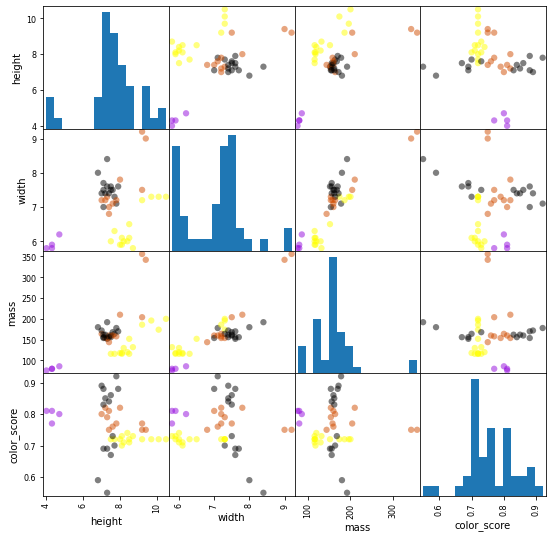

In [6]:
# plotting a scatter matrix
from matplotlib import cm

X = fruits[['height', 'width', 'mass', 'color_score']]
y = fruits['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)

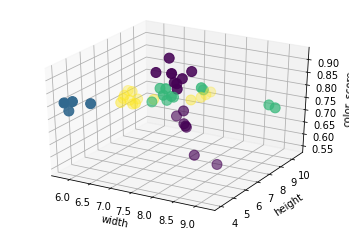

In [7]:
# plotting a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train['width'], X_train['height'], X_train['color_score'], c = y_train, marker = 'o', s=100)
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('color_score')
plt.show()

#Create train-test split
Comme l'algorithme se calibre à partir du jeu d'apprentissage, on s'attend à avoir de bons résultats si on essaie d'évaluer les résultats à partir de ce jeu-là, même si quelques points sont faux, comme on le voit un peu plus bas dans le "decision boundary".

**Le problème est de vérifier si l'apprentissage de l'algorithme se généralise à des données du monde réel.** En effet, le jeu d'apprentissage est un petit sous-ensemble des vraies données rencontrées dans le monde réel. L'algorithme peut donc donner de très bons résultats avec le jeu d'apprentissage, et des résultats très moyens avec des données qui ne faisaient pas partie de son apprentissage.

Pour essayer de résoudre ce problème, on découpe aléatoirement les données en 2:
- **le jeu d'apprentissage, qui contient par défaut 75% des données**. L'algorithme va se calibrer sur ce jeu-là.
- **le jeu de test, qui contient le reste des données**. On va estimer les résultats de l'apprentissage sur ce jeu-là

Remarque: comme le découpage des données est aléatoire, on ne va pas forcément avoir le même apprentissage à chaque fois, et donc on pourra avoir des résultats différents. **Ici nous utilisons random_state=0 pour que le découpage ne soit pas aléatoire, pour que ce cours donne toujours les mêmes résultats. Dans la vraie vie, il est important que le découpage soit le plus aléatoire possible,** afin de se prémunir contre certains biais: par exemple, si les données sont triées, certaines catégories pourraient se retrouver uniquement au début du jeu de données. Si l'algorithme apprend par lots, les derniers lots ont davantage de poids que les premiers et l'algorithme ne pourrait pas généraliser correctement ses prédictions.

In [ ]:
# For this example, we use the mass, width, and height features of each fruit instance
X = fruits[['mass', 'width', 'height']]
y = fruits['fruit_label']

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##Create classifier object

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

##Train the classifier (fit the estimator) using the training data¶

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

##Estimate the accuracy of the classifier on future data, using the test data¶
Accuracy is the most commonly used metric for estimating the results of a Machine Learning or Deep Learning algorithm. It is equal to the percentage of correct answers:

$accuracy = \frac{nbCorrectResults}{nbTotalResults}$

Here, we obtain 53.33%, which is a bad result. **In this example, the worst result is 25%: it corresponds to chosing randomly a class between the 4 possible ones.**

**We will see in chapter "1.3 - Normalization" how to improve the results of this algorithm.** This trick will work as well with other algorithms, including neural networks.

In the next chapters, we will see that accuracy is adapted to balanced datasets, ie. the datasets in which categories are represented in equal proportions. For example, if there are 4 categories, the training set is balanced if it contains around 25% of each.

You should use other metrics, that we will introduce in the next chapters, when the dataset is imbalanced.

In [ ]:
knn.score(X_test, y_test)

0.5333333333333333

##Use the trained k-NN classifier model to classify new, previously unseen objects¶

In [ ]:
# first example: a small fruit with mass 20g, width 4.3 cm, height 5.5 cm
fruit_prediction = knn.predict([[20, 4.3, 5.5]])
lookup_fruit_name[fruit_prediction[0]]

'mandarin'

In [ ]:
# second example: a larger, elongated fruit with mass 100g, width 6.3 cm, height 8.5 cm
fruit_prediction = knn.predict([[100, 6.3, 8.5]])
lookup_fruit_name[fruit_prediction[0]]

'lemon'

#Bias - variance tradeoff
In a word:

![image](http://www.eyrignoux.com.fr/coursIA/machineLearning/BiasVariance.PNG)
- Intuitively, bias is the "orientation" of your model. The more important it is, the fastest you get results with fewer examples, but those results might be "biased" and fail to generalize.

**When a model is less complex, it ignores relevant information, and error due to bias is high: the model is "biased" in its way of ignoring some features and taking others into account. As the model becomes more complex, error due to bias decreases.**

- Intuitively, variance is the possible richness of the results. Given similar features, the variance of the model is a measure of the differences in the results. A good model has a low variance: similar data should produce similar results.

**When a model is less complex, error due to variance is low. Error due to variance increases as complexity increases.**

See more complete explanations here: https://gallery.mailchimp.com/dc3a7ef4d750c0abfc19202a3/files/37024aa7-8550-44d9-aa5e-e80aa82ec436/Ng_MLY03.pdf

And a nice visual explanation here: http://www.r2d3.us/visual-intro-to-machine-learning-part-2/


#Plot the decision boundaries of the k-NN classifier

/content/adspy_shared_utilities.py:172: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X_mat = X[['height', 'width']].as_matrix()
/content/adspy_shared_utilities.py:173: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_mat = y.as_matrix()


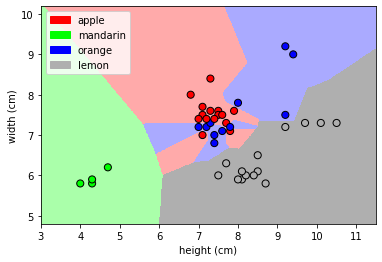

In [ ]:
from adspy_shared_utilities import plot_fruit_knn

plot_fruit_knn(X_train, y_train, 1, 'uniform')   # we choose 5 nearest neighbors

##How sensitive is k-NN classification accuracy to the choice of the 'k' parameter?¶

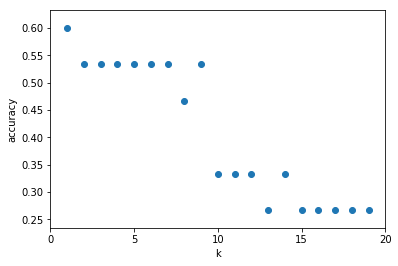

In [ ]:
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

##How sensitive is k-NN classification accuracy to the train/test split proportion?¶

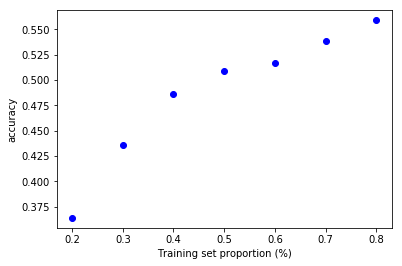

In [ ]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');